In [1]:
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

import zipfile
import os
import shutil
import random

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.Fibrosis = data.Fibrosis.replace('-', np.NaN)

In [4]:
data.Equipment.value_counts()

IU22        101
LOGIQE9      99
iu22         78
EUB-7500     70
eub-7500     45
S2000        28
s2000         5
Name: Equipment, dtype: int64

In [5]:
# to upper character

data['Equipment'] = data['Equipment'].apply(lambda x: x.upper())

In [6]:
def sort_by_equipment(equipment):
    return data[(data['Equipment'] == equipment)]['Fibrosis'].value_counts()

In [7]:
sort_by_equipment('EUB-7500')

4    49
3    24
0    16
2     9
1     8
Name: Fibrosis, dtype: int64

In [8]:
sort_by_equipment('LOGIQE9')

0    43
4    29
3    11
1     3
2     1
Name: Fibrosis, dtype: int64

In [9]:
# train with 'EUB-7500'
# train with 'LOGIQE9'

In [10]:
data.Fibrosis = pd.to_numeric(data.Fibrosis)

In [11]:
# divide the data by Equipment

def fill_zero(f):
    for i in range(len(f)):
        f[i] = f[i].zfill(4)
    
    return f

def sort_by_tool(equipment):
    f_neg = data[(data['Fibrosis']==0) & (data['Equipment']==equipment.upper())].number.astype(str).tolist()
    f_pos = data[(data['Fibrosis']!=0) & (data['Equipment']==equipment.upper())].number.astype(str).tolist()
    
    # fill the zeros (for foloder name)
    f_neg = fill_zero(f_neg)
    f_pos = fill_zero(f_pos)
    
    return f_neg, f_pos


def move_to_tmp(local_zip, equipment, base_loc):
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('/tmp/Liver_'+equipment)
    zip_ref.close()

def make_folder(base_loc):
    try:
        os.mkdir(base_loc)
        os.mkdir(base_loc+'/training')
        os.mkdir(base_loc+'/training/f0')
        os.mkdir(base_loc+'/training/f1')
        os.mkdir(base_loc+'/testing')
        os.mkdir(base_loc+'/testing/f0')
        os.mkdir(base_loc+'/testing/f1')

    except OSError:
        pass

def move_to_folder(f_, folder_loc, split, base_loc):
    split = int(len(f_)*(1-split))
    
    f_train = f_[:split]
    f_test = f_[split:]
    
    print(folder_loc,':',len(f_train))
    print(folder_loc,':',len(f_test))
    
    new_name = 0
    for folder_name in f_train:
        for root, subdirs, files in os.walk(base_loc+'/'+folder_name):
            for f in files:
                if 'mask' not in f:
                    # file_name change
                    try:
                        file_to_change = os.path.join(root, f)
                        dst = str(new_name)+'.tif'
                        dst = os.path.join(root, dst)
                        os.rename(file_to_change, dst)
                        new_name += 1
                        tmp = base_loc+'/training/'+folder_loc
                        # file move
                        shutil.move(dst, tmp)
                    except:
                        print('error')
    
    new_name = 0                    
    for folder_name in f_test:
        for root, subdirs, files in os.walk(base_loc+'/'+folder_name):
            for f in files:
                if 'mask' not in f:
                    # file_name change
                    try:
                        file_to_change = os.path.join(root, f)
                        dst = str(new_name)+'.tif'
                        dst = os.path.join(root, dst)
                        os.rename(file_to_change, dst)
                        new_name += 1
                        tmp = base_loc+'/testing/'+folder_loc
                        # file move
                        shutil.move(dst, tmp)
                    except:
                        print('error')

In [12]:
def train_test_split(equipment, local_zip, split_size):
    equipment = equipment.upper()
    f_false, f_true = sort_by_tool(equipment)
    
    random.shuffle(f_false)
    random.shuffle(f_true)
    
    make_folder(base_loc)
    move_to_tmp(local_zip, equipment, base_loc)
    
    move_to_folder(f_false, 'f0', 0.2, base_loc)
    move_to_folder(f_true, 'f1', 0.2, base_loc)

In [13]:
def ImageGenerator(base_loc):
    TRAINING_DIR = base_loc+'/training'
    train_datagen = ImageDataGenerator(rescale = 1.0/255.)

    train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                       batch_size=64,
                                                       class_mode='binary',
                                                       target_size=(600,800),
                                                       color_mode='grayscale') # target_size = (height, width)

    TESTING_DIR = base_loc+'/testing'
    test_datagen = ImageDataGenerator(rescale = 1.0/255.)

    test_generator = train_datagen.flow_from_directory(TESTING_DIR,
                                                       batch_size=32,
                                                       class_mode='binary',
                                                       target_size=(600,800), 
                                                       color_mode='grayscale')
    
    return train_generator, test_generator

In [14]:
# change
equipment = 'LOGIQE9' 
local_zip = '../../../Data/Liver.zip'
base_loc = '/tmp/Liver_' + equipment

In [15]:
train_test_split(equipment, local_zip, 0.2)

f0 : 34
f0 : 9
f1 : 44
f1 : 12


In [20]:
# training

In [16]:
print("Training Fibrosis 0:", len(os.listdir(base_loc+'/training/f0')))
print("Testing Fibrosis 0:", len(os.listdir(base_loc+'/testing/f0')))
print("-"*25)
print("Training Fibrosis 1:", len(os.listdir(base_loc+'/training/f1')))
print("Testing Fibrosis 1:", len(os.listdir(base_loc+'/testing/f1')))

Training Fibrosis 0: 239
Testing Fibrosis 0: 73
-------------------------
Training Fibrosis 1: 363
Testing Fibrosis 1: 47


In [17]:
train_generator, test_generator = ImageGenerator(base_loc)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5,5), activation='relu', input_shape=(600,800,1)),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(16, (5,5), activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Found 602 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 596, 796, 6)       156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 298, 398, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 294, 394, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 147, 197, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 463344)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               59308160  
________________________________________

In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.99):
            print("\nReached 99.0% accuracy so cancelling training")
            self.model.stop_training = True

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=["acc"])

history = model.fit_generator(train_generator,
                              epochs=50,
                              validation_data=test_generator,
                              callbacks = [myCallback()])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
10/10 [==============================] - 2s 221ms/step - loss: 0.7014 - acc: 0.6179 - val_loss: 0.8091 - val_acc: 0.3917
Epoch 2/50
10/10 [==============================] - 2s 173ms/step - loss: 0.6676 - acc: 0.6196 - val_loss: 0.6804 - val_acc: 0.5833
Epoch 3/50
10/10 [==============================] - 2s 172ms/step - loss: 0.6079 - acc: 0.6860 - val_loss: 0.6898 - val_acc: 0.5417
Epoch 4/50
10/10 [==============================] - 2s 177ms/step - loss: 0.5827 - acc: 0.7010 - val_loss: 0.6960 - val_acc: 0.5500
Epoch 5/50
10/10 [==============================] - 2s 186ms/step - loss: 0.5683 - acc: 0.7143 - val_loss: 0.6693 - val_acc: 0.5750
Epoch 6/50
10/10 [==============================] - 2s 185ms/step - loss: 0.5165 - acc: 0.7575 - val_loss: 1.0367 - val_acc: 0.4667
Epoch 7/50
10/10 [==============================] - 2s 173ms/step - loss: 0.5134 - acc: 0.7575 - val_loss: 0.7671 - val_acc: 0.5750


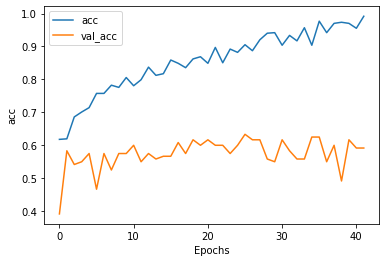

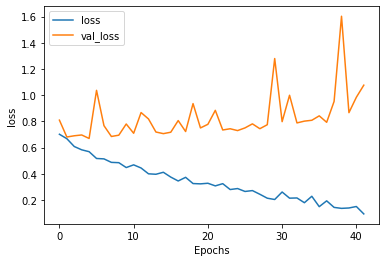

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [21]:
# delete the data

shutil.rmtree('/tmp/Liver_'+equipment)

In [ ]:
import os, signal

os.kill(os.getpid(),signal.SIGKILL)